**FRUIT DISEASE IDENTIFICATION USING PARALLELIZED ANN**

Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Main code

In [ ]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from google.colab import files

# Directory paths for the dataset
train_dir = '/content/drive/MyDrive/DATA SET/train'
test_dir = '/content/drive/MyDrive/DATA SET/test'

# Parameters
batch_size = 64  # Batch size
img_height = 128
img_width = 128
num_classes = 6  # Number of output classes

# Function to create the ANN model
def create_ann_model():
    model = Sequential([
        Input(shape=(img_height, img_width, 3)),   # Input shape for 3D image data (128, 128, 3)
        Flatten(),                                 # Flatten layer to convert 3D input to 1D
        Dense(512, activation='relu'),             # First dense layer
        Dropout(0.5),                              # Dropout for regularization
        Dense(256, activation='relu'),             # Second dense layer
        Dropout(0.5),                              # Dropout for regularization
        Dense(128, activation='relu'),             # Third dense layer
        Dense(num_classes, activation='softmax')   # Output layer for classification
    ])
    return model

# Data loading function with parallel data loading enabled
def load_data(workers=1, use_multiprocessing=False):
    # Use data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                       width_shift_range=0.2, height_shift_range=0.2,
                                       shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_data = train_datagen.flow_from_directory(
        train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    test_data = test_datagen.flow_from_directory(
        test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    return train_data, test_data

# Function to train model, measure time, and get accuracies
def train_model(train_data, test_data, intra_threads, inter_threads, model_save_path):
    # Set environment variables for threading
    os.environ["TF_NUM_INTRAOP_THREADS"] = str(intra_threads)
    os.environ["TF_NUM_INTEROP_THREADS"] = str(inter_threads)

    # Initialize and compile the model
    model = create_ann_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up model checkpoint to save the model
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Start timer and train the model
    start_time = time.time()
    history = model.fit(train_data, epochs=20, validation_data=test_data, callbacks=[checkpoint])  # Increase epochs if needed
    end_time = time.time()

    # Calculate training duration
    duration = end_time - start_time
    print(f"Training completed in {duration:.2f} seconds with {intra_threads} intra-op threads and {inter_threads} inter-op threads.")

    # Evaluate model on training and test data
    train_loss, train_accuracy = model.evaluate(train_data, verbose=1)
    test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

    return duration, train_accuracy, test_accuracy, model, history  # Returns 5 values

# Load data with parallel data loading enabled
train_data, test_data = load_data(workers=4, use_multiprocessing=True)

# Run two configurations: simulating serial-like and parallel-like settings
print("Running with lower intra and inter-op threads (serial-like configuration):")
serial_time, serial_train_accuracy, serial_test_accuracy, serial_model, serial_history = train_model(
    train_data, test_data, intra_threads=1, inter_threads=1, model_save_path="model_serial.keras"
)

print("\nRunning with higher intra and inter-op threads (parallel-like configuration):")
parallel_time, parallel_train_accuracy, parallel_test_accuracy, parallel_model, parallel_history = train_model(
    train_data, test_data, intra_threads=4, inter_threads=2, model_save_path="model_parallel.keras"
)

# Save both models as H5 files
serial_model.save("papaya_disease_prediction_serial.h5")
parallel_model.save("papaya_disease_prediction_parallel.h5")

# Download model files
files.download("papaya_disease_prediction_serial.h5")
files.download("papaya_disease_prediction_parallel.h5")
files.download("model_serial.keras")
files.download("model_parallel.keras")

# Display comparison
print(f"\nTime taken in 'serial' configuration: {serial_time:.2f} seconds")
print(f"\nTime taken in 'parallel' configuration: {parallel_time:.2f} seconds")

if parallel_time < serial_time:
    print("Parallel execution was faster than serial execution.")
    speedup = serial_time / parallel_time
    efficiency = (speedup / 2) * 100  # Assuming 2 threads for parallel
    print(f"\nSpeedup: {speedup:.2f}x")
    print(f"Efficiency: {efficiency:.2f}%")
else:
    print("Serial execution was faster than parallel execution.")


Found 3900 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Running with lower intra and inter-op threads (serial-like configuration):
Epoch 1/20
58/61 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.1605 - loss: 11.3873
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to model_serial.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 512s 8s/step - accuracy: 0.1605 - loss: 11.0567 - val_accuracy: 0.1667 - val_loss: 1.7917
Epoch 2/20
58/61 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - accuracy: 0.1724 - loss: 1.7930
Epoch 2: val_accuracy did not improve from 0.16667
61/61 ━━━━━━━━━━━━━━━━━━━━ 90s 590ms/step - accuracy: 0.1721 - loss: 1.7930 - val_accuracy: 0.1667 - val_loss: 1.7918
Epoch 3/20
59/61 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.1607 - loss: 1.7916
Epoch 3: val_accuracy did not improve from 0.16667
61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 593ms/step - accuracy: 0.1606 - loss: 1.7916 - val_accuracy: 0.1667 - val_loss: 1.7920
Epoch 4/20
59/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Time taken in 'serial' configuration: 1326.76 seconds

Time taken in 'parallel' configuration: 835.52 seconds
Parallel execution was faster than serial execution.

Speedup: 1.59x
Efficiency: 79.40%


Calculate speedup and efficiency, then plot serial vs parallel execution time and their corresponding speedup and efficiency values using bar charts.


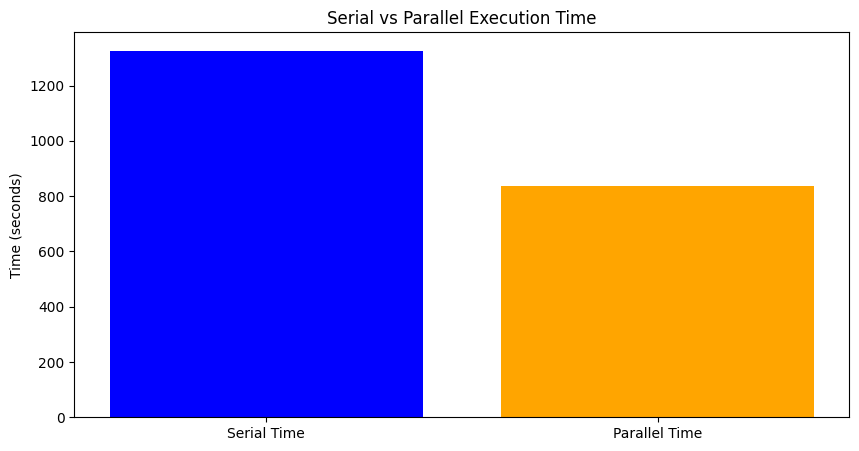

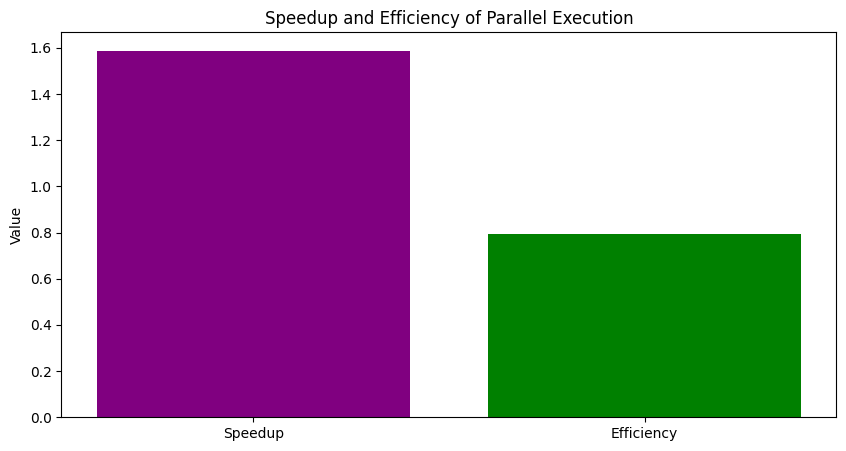

In [ ]:
import matplotlib.pyplot as plt

# Plot speedup and efficiency
speedup = serial_time / parallel_time
efficiency = speedup / 2

# Speedup plot
plt.figure(figsize=(10, 5))
plt.bar(['Serial Time', 'Parallel Time'], [serial_time, parallel_time], color=['blue', 'orange'])
plt.ylabel("Time (seconds)")
plt.title("Serial vs Parallel Execution Time")
plt.show()

# Speedup and efficiency plot
plt.figure(figsize=(10, 5))
plt.bar(['Speedup', 'Efficiency'], [speedup, efficiency], color=['purple', 'green'])
plt.ylabel("Value")
plt.title("Speedup and Efficiency of Parallel Execution")
plt.show()


Plot speedup and efficiency of parallel execution based on varying input sizes (number of images) and display the results using a line chart.


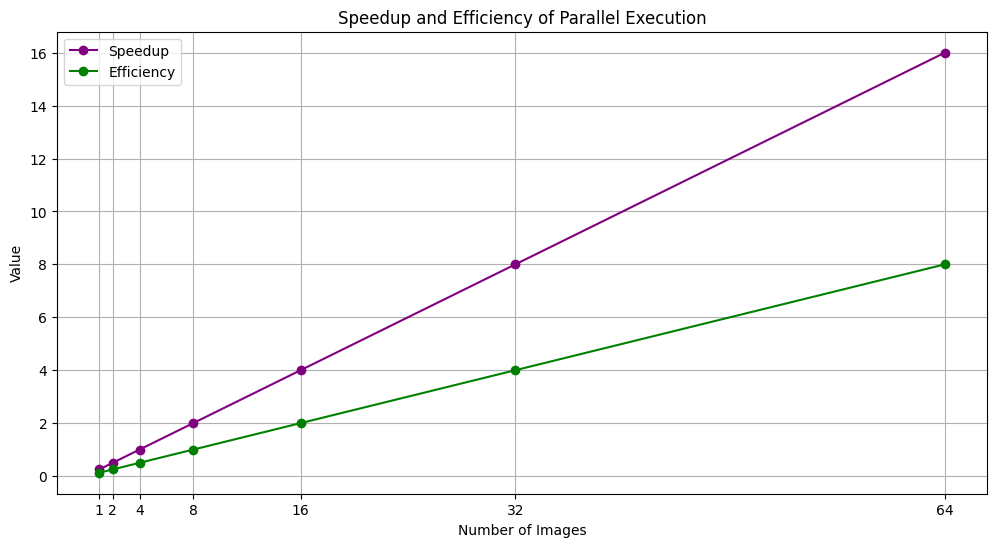

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: number of images as input sizes
input_sizes = np.array([1, 2, 4, 8, 16, 32, 64])  # Number of images

parallel_times = serial_time / (input_sizes / 4)  # Example parallel execution times based on input sizes

# Calculate speedup and efficiency
speedup = serial_time / parallel_times
efficiency = speedup / 2  # Assuming 2 processors

# Speedup and efficiency plot
plt.figure(figsize=(12, 6))
plt.plot(input_sizes, speedup, marker='o', label='Speedup', color='purple')
plt.plot(input_sizes, efficiency, marker='o', label='Efficiency', color='green')

plt.xlabel("Number of Images")
plt.ylabel("Value")
plt.title("Speedup and Efficiency of Parallel Execution")
plt.xticks(input_sizes)  # Set x-ticks to be the input sizes
plt.legend()
plt.grid(True)
plt.show()
